Testing logic with molecules.

In [1]:
%reload_ext autoreload
%autoreload 2

import rdkit
rdkit.Chem.Draw.IPythonConsole.ipython_maxProperties = -1

import dgym as dg

# load all data
path = '../../dgym-data'

deck = dg.MoleculeCollection.load(
    f'{path}/DSi-Poised_Library_annotated.sdf',
    reactant_names=['reagsmi1', 'reagsmi2', 'reagsmi3']
)

reactions = dg.ReactionCollection.from_json(
    path = f'{path}/All_Rxns_rxn_library.json',
    smarts_col = 'reaction_string',
    classes_col = 'functional_groups'
)

building_blocks = dg.datasets.disk_loader(f'{path}/Enamine_Building_Blocks_Stock_262336cmpd_20230630.sdf')
fingerprints = dg.datasets.fingerprints(f'{path}/Enamine_Building_Blocks_Stock_262336cmpd_20230630_atoms.fpb')

import torch
import pyarrow.parquet as pq
table = pq.read_table('../../dgym-data/sizes.parquet')[0]
sizes = torch.tensor(table.to_numpy())

In [2]:
from dgym.molecule import Molecule
from dgym.envs.designer import Designer, Generator
from dgym.envs.drug_env import DrugEnv
from dgym.agents import SequentialDrugAgent
from dgym.agents.exploration import EpsilonGreedy
from dgym.experiment import Experiment

designer = Designer(
    Generator(building_blocks, fingerprints, sizes),
    reactions,
    cache = True
)

In [78]:
designer.reset_cache()
res = designer.design(deck[0], 1, mode='random')[0]
molecule = designer.design(res, 1, mode='grow')[0]

In [79]:
import json

print(json.dumps(molecule.dump(), indent=4))

{
    "product": "Cc1nc(-c2c(C)c(C)nn(C)c2=O)sc1C(=O)N(C(=O)C(O)c1ccc(F)cc1Br)[C@@]12CC[C@@H](C[C@H]1NC(=O)OC(C)(C)C)C2",
    "reaction": "13_Carboxylate_and_Amine",
    "reactants": [
        {
            "product": "CC(C)(C)OC(=O)N[C@@H]1C[C@@H]2CC[C@@]1(NC(=O)C(O)c1ccc(F)cc1Br)C2",
            "reaction": "13_Carboxylate_and_Amine",
            "reactants": [
                {
                    "product": "CC(C)(C)OC(=O)N[C@@H]1C[C@@H]2CC[C@@]1(N)C2"
                },
                {
                    "product": "O=C(O)C(O)c1ccc(F)cc1Br"
                }
            ]
        },
        {
            "product": "Cc1nc(-c2c(C)c(C)nn(C)c2=O)sc1C(=O)O"
        }
    ]
}


In [183]:
import itertools

def generate_products(serialized_tree, generator):
    """
    Generates LazyReaction products based on a serialized reaction tree.
    
    Parameters:
    - serialized_tree: dict, the serialized reaction tree including SMILES strings.
    - generator: Generator object, used for generating molecules.
    - building_blocks: Any necessary data or objects required for molecule generation.
    
    Returns:
    - A generator for LazyReaction products.
    """
    # Base case: If the tree is a simple molecule, return it directly or based on the generation mode
    if 'reactants' not in serialized_tree:
        product = serialized_tree['product']
        mode = serialized_tree.get('mode', 'original')
        temperature = serialized_tree.get('temperature', 0.0)
        return generator(product, mode=mode, temperature=temperature)

    # Recursive case: Construct reactants and apply LazyReaction
    if 'reaction' in serialized_tree \
        and 'reactants' in serialized_tree:
        reactants = [generate_products(reactant, generator)
                     for reactant in serialized_tree['reactants']]
        reaction = reactions[serialized_tree['reaction']]
        return reaction.run(reactants)

    raise Exception('`reaction_tree` must include a reaction or reactants.')

In [242]:
reaction_tree = molecule.dump()

In [243]:
print(json.dumps(reaction_tree, indent=4))

{
    "product": "Cc1nc(-c2c(C)c(C)nn(C)c2=O)sc1C(=O)N(C(=O)C(O)c1ccc(F)cc1Br)[C@@]12CC[C@@H](C[C@H]1NC(=O)OC(C)(C)C)C2",
    "reaction": "13_Carboxylate_and_Amine",
    "reactants": [
        {
            "product": "CC(C)(C)OC(=O)N[C@@H]1C[C@@H]2CC[C@@]1(NC(=O)C(O)c1ccc(F)cc1Br)C2",
            "reaction": "13_Carboxylate_and_Amine",
            "reactants": [
                {
                    "product": "CC(C)(C)OC(=O)N[C@@H]1C[C@@H]2CC[C@@]1(N)C2"
                },
                {
                    "product": "O=C(O)C(O)c1ccc(F)cc1Br"
                }
            ]
        },
        {
            "product": "Cc1nc(-c2c(C)c(C)nn(C)c2=O)sc1C(=O)O"
        }
    ]
}


In [246]:
reaction_tree['reactants'][1]['mode'] = 'similar'
reaction_tree['reactants'][0]['reactants'][0]['mode'] = 'original'

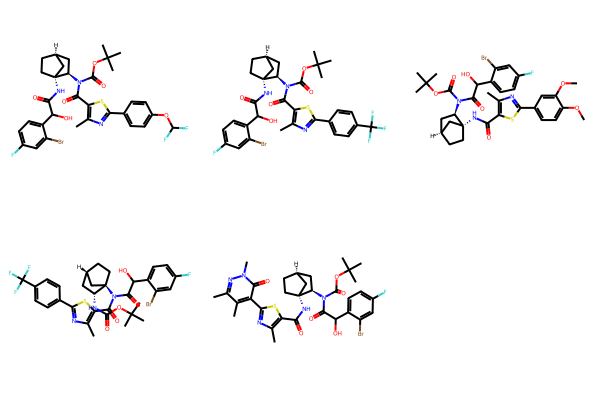

In [256]:
generator = Generator(building_blocks, fingerprints, sizes)
products = generate_lazy_products(reaction_tree, generator)
analogs = set([next(products) for _ in range(5)])

from rdkit.Chem.Draw import MolsToGridImage

MolsToGridImage(
    [m.mol for m in analogs],
    molsPerRow=3,
)